### On commence par modifier le code "adrs_insta.py" pour visualiser l'erreur aux temps T/2 et T pour différents maillages uniformes.

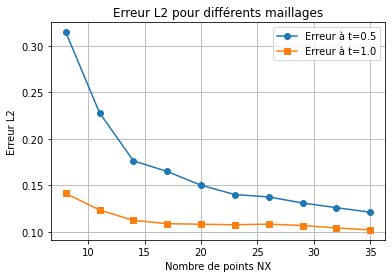

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

def fex(NX, dx, time):
    F = np.zeros(NX)
    Tex = np.zeros(NX)
    Text = np.zeros(NX)
    Texx = np.zeros(NX)
    
    for j in range(1, NX-1):
        v = (np.exp(-1000*((j - NX/3)/NX)**2) + np.exp(-10*np.exp(-1000*((j - NX/3)/NX)**2))) * np.sin(5*j*math.pi/NX)
        Tex[j] = np.sin(4*math.pi*time) * v
        Text[j] = 4*math.pi*np.cos(4*math.pi*time) * v

    for j in range(1, NX-1):
        Texx[j] = (Tex[j+1] - Tex[j-1]) / (2*dx)
        Txx = (Tex[j+1] - 2*Tex[j] + Tex[j-1]) / (dx**2)
        F[j] = V*Texx[j] - K*Txx + lamda*Tex[j] + Text[j]

    return F, Tex, Texx

# PARAMÈTRES PHYSIQUES ET INIT
K = 0.1
L = 1.0
V = 1
lamda = 1
Time_final = 1.0

# Initialisations pour erreur
NX = 5
niter_refinement = 10
eps = 1e-4

NX_tab = []
Err_tab1 = []
Err_tab2 = []

for iter in range(niter_refinement):
    NX += 3
    dx = L / (NX - 1)
    dt = dx**2 / (V*dx + K + dx**2)

    x = np.linspace(0.0, 1.0, NX)
    T = np.zeros(NX)
    time = 0
    n = 0

    alpha = np.zeros(4)
    for irk in range(4):
        alpha[irk] = 1 / (4 - irk)

    Texx = np.zeros(NX)

    time_err1 = False
    F, Tex, Texx = fex(NX, dx, time)

    while time < Time_final:
        F, Tex, Texx = fex(NX, dx, time)
        dt = dx**2 / (V*dx + 2*K + abs(np.max(F))*dx**2)
        T0 = T.copy()

        for irk in range(4):
            for j in range(1, NX-1):
                xnu = K + 0.5*dx*abs(V)
                Tx = (T[j+1] - T[j-1]) / (2*dx)
                Txx = (T[j-1] - 2*T[j] + T[j+1]) / (dx**2)
                RHS = dt * (-V*Tx + xnu*Txx - lamda*T[j] + F[j])
                T[j] = T0[j] + RHS * alpha[irk]

        time += dt
        n += 1

        err_l2 = np.sqrt(np.sum((T - Tex)**2) * dx)
        
        if not time_err1 and abs(time - 0.5) < dt:
            NX_tab.append(NX)
            Err_tab1.append(err_l2)
            time_err1 = True

    # Error at final time
    F, Tex, Texx = fex(NX, dx, time)
    err_l2 = np.sqrt(np.sum((T - Tex)**2) * dx)
    Err_tab2.append(err_l2)

# 📈 PLOT des erreurs L2
plt.figure()
plt.plot(NX_tab, Err_tab1, 'o-', label="Erreur à t=0.5")
plt.plot(NX_tab, Err_tab2, 's-', label="Erreur à t=1.0")
plt.xlabel("Nombre de points NX")
plt.ylabel("Erreur L2")
plt.title("Erreur L2 pour différents maillages")
plt.legend()
plt.grid(True)
-que donne le maillage adaptatif avec controle de metrique stationnaire (base sur la solution finale en t=Time).
-que donne le maillage adaptatif avec controle de metrique stationnaire (base sur la solution finale en t=Time).


### On modifie maintenant le code pour visualiser l'evolution de l'erreur au point milieu du domaine pour differents Runge-Kutta (1-4).

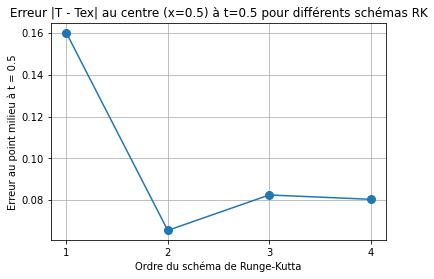

In [7]:
# PARAMÈTRES PHYSIQUES
K = 0.1
L = 1.0
V = 1
lamda = 1

Time_target = 0.5
NX = 101  # Maille fixe raisonnablement fine
dx = L / (NX - 1)
x = np.linspace(0.0, 1.0, NX)
center_index = NX // 2

# Stockage des erreurs pour chaque ordre de RK
rk_orders = [1, 2, 3, 4]
midpoint_errors = []

for irk_max in rk_orders:
    # Coefficients RK
    alpha = np.zeros(irk_max)
    for irk in range(irk_max):
        alpha[irk] = 1 / (irk_max - irk)

    # Initialisation
    T = np.zeros(NX)
    time = 0

    while time < Time_target:
        F, Tex, Texx = fex(NX, dx, time)
        dt = dx**2 / (V*dx + 2*K + abs(np.max(F)) * dx**2)

        # Si on dépasse le temps cible, on ajuste dt pour tomber pile sur 0.5
        if time + dt > Time_target:
            dt = Time_target - time

        T0 = T.copy()

        for irk in range(irk_max):
            for j in range(1, NX-1):
                xnu = K + 0.5 * dx * abs(V)
                Tx = (T[j+1] - T[j-1]) / (2*dx)
                Txx = (T[j-1] - 2*T[j] + T[j+1]) / (dx**2)
                RHS = dt * (-V*Tx + xnu*Txx - lamda*T[j] + F[j])
                T[j] = T0[j] + RHS * alpha[irk]

        time += dt

    # Calcul erreur point milieu à t=0.5
    F, Tex, Texx = fex(NX, dx, Time_target)
    error_mid = abs(T[center_index] - Tex[center_index])
    midpoint_errors.append(error_mid)

# 📈 Affichage
plt.figure()
plt.plot(rk_orders, midpoint_errors, 'o-', markersize=8)
plt.xticks(rk_orders)
plt.xlabel("Ordre du schéma de Runge-Kutta")
plt.ylabel("Erreur au point milieu à t = 0.5")
plt.title("Erreur |T - Tex| au centre (x=0.5) à t=0.5 pour différents schémas RK")
plt.grid(True)
plt.show()


### On travaille maintenant sur le code "adrs_multiple_mesh_adap_insta.py". on le modifie pour visualiser la solutions à différents instants


=== Iteration de raffinement 1, NX = 30 ===
Pas de temps dt = 0.009150383566684774
Fin itération 1: NX=30, temps final=2.000, résidu=0.05416

=== Iteration de raffinement 2, NX = 30 ===
Pas de temps dt = 0.005083882122341518
Fin itération 2: NX=28, temps final=2.000, résidu=0.02491

=== Iteration de raffinement 3, NX = 28 ===
Pas de temps dt = 0.005002218908831225
Fin itération 3: NX=29, temps final=2.000, résidu=0.05088


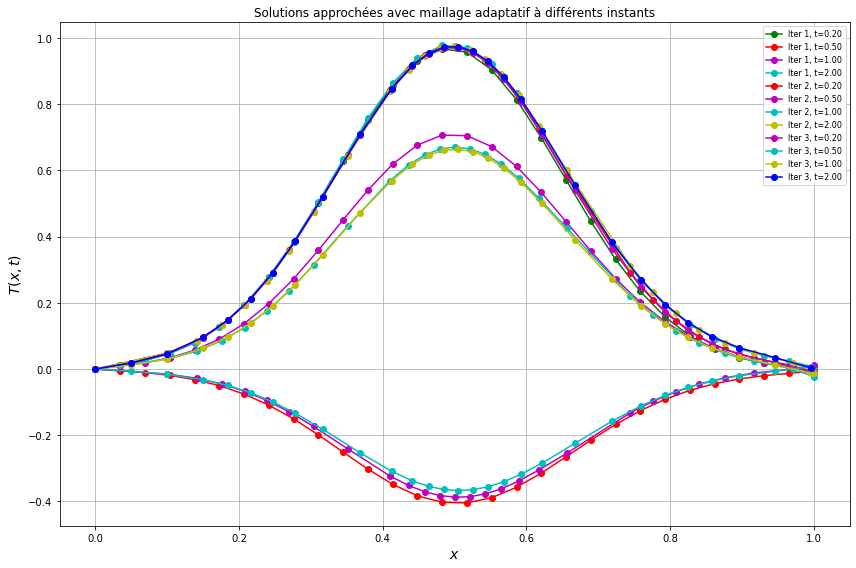

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# PHYSICAL PARAMETERS
K = 0.01     # Diffusion coefficient
xmin = 0.0
xmax = 1.0    
Time = 2.0   # Total simulation time

V = 1.0
lamda = 1.0
freq = 7.0

# Mesh adaptation parameters
niter_refinement = 5  # nombre d'itérations d'adaptation du maillage
hmin = 0.01
hmax = 0.1    # plus petit pour maillage plus fin
err = 0.01

# NUMERICAL PARAMETERS
NX = 30       # points initiaux
NT = 10000    # max time steps
eps = 0.001

# Temps auxquels on veut enregistrer les solutions
save_times = [0.2, 0.5, 1.0, 2.0]

# Pour stocker les solutions : dict(iteration) -> dict(temps) -> (x, T)
solutions = {}

iter = 0
NX0 = 0
hloc = np.ones(NX) * hmax * 0.5

while np.abs(NX0 - NX) > 1 and iter < niter_refinement:
    iter += 1
    print(f"\n=== Iteration de raffinement {iter}, NX = {NX} ===")
    itertab = 1. / NX
    
    # Initial mesh ou maillage adaptatif
    if iter == 1:
        x = np.linspace(xmin, xmax, NX)
    else:
        x = x  # maillage déjà adapté à la fin de la précédente itération

    T = np.zeros(NX)

    # Raffinement adaptatif du maillage (sauf à la 1ère itération)
    if iter > 1:
        xnew = [xmin]
        Tnew = [T[0]]
        nnew = 1
        while xnew[-1] < xmax - hmin:
            for i in range(NX - 1):
                if xnew[-1] >= x[i] and xnew[-1] <= x[i + 1] and xnew[-1] < xmax - hmin:
                    hll = (hloc[i] * (x[i + 1] - xnew[-1]) + hloc[i + 1] * (xnew[-1] - x[i])) / (x[i + 1] - x[i])
                    hll = min(max(hmin, hll), hmax)
                    nxt_x = min(xmax, xnew[-1] + hll)
                    xnew.append(nxt_x)
                    # interpolation linéaire
                    un = (T[i] * (x[i + 1] - nxt_x) + T[i + 1] * (nxt_x - x[i])) / (x[i + 1] - x[i])
                    Tnew.append(un)
                    nnew += 1
        NX0 = NX
        NX = nnew
        x = np.array(xnew)
        T = np.zeros(NX)

    # Préparation des champs et paramètres
    F = np.zeros(NX)
    RHS = np.zeros(NX)
    metric = np.zeros(NX)
    hloc = np.ones(NX) * hmax * 0.5

    Tex = np.zeros(NX)
    for j in range(1, NX - 1):
        Tex[j] = np.exp(-20 * (x[j] - 0.5 * (xmin + xmax)) ** 2)

    dt = 1.e30
    for j in range(1, NX - 1):
        Tx = (Tex[j + 1] - Tex[j - 1]) / (x[j + 1] - x[j - 1])
        Txip1 = (Tex[j + 1] - Tex[j]) / (x[j + 1] - x[j])
        Txim1 = (Tex[j] - Tex[j - 1]) / (x[j] - x[j - 1])
        Txx = (Txip1 - Txim1) / (0.5 * (x[j + 1] + x[j]) - 0.5 * (x[j] + x[j - 1]))
        F[j] = V * Tx - K * Txx + lamda * Tex[j]
        dt = min(dt, 0.25 * (x[j + 1] - x[j - 1]) ** 2 / (V * np.abs(x[j + 1] - x[j - 1]) + 4 * K + np.abs(F[j]) * (x[j + 1] - x[j - 1]) ** 2))

    print(f"Pas de temps dt = {dt}")

    # Boucle temporelle
    n = 0
    t = 0.0
    saved = {time: False for time in save_times}
    solutions[iter] = {}

    while n < NT and t < Time:
        n += 1
        dt = min(dt, Time - t)
        t += dt

        # Calcul du résidu (pour info)
        res = 0
        for j in range(1, NX - 1):
            visnum = 0.25 * (0.5 * (x[j + 1] + x[j]) - 0.5 * (x[j] + x[j - 1])) * np.abs(V)
            xnu = K + visnum
            Tx = (T[j + 1] - T[j - 1]) / (x[j + 1] - x[j - 1])
            Txip1 = (T[j + 1] - T[j]) / (x[j + 1] - x[j])
            Txim1 = (T[j] - T[j - 1]) / (x[j] - x[j - 1])
            Txx = (Txip1 - Txim1) / (0.5 * (x[j + 1] + x[j]) - 0.5 * (x[j] + x[j - 1]))
            src = F[j] * np.sin(freq * t) + Tex[j] * np.cos(freq * t) * freq
            RHS[j] = dt * (-V * Tx + xnu * Txx - lamda * T[j] + src)
            metric[j] += min(1. / hmin ** 2, max(1. / hmax ** 2, abs(Txx) / err))
            res += abs(RHS[j])

        metric[0] = metric[1]
        metric[-1] = metric[-2]

        for j in range(1, NX - 1):
            T[j] += RHS[j]
            RHS[j] = 0

        T[0] = 0
        T[-1] = 2 * T[-2] - T[-3]

        # Sauvegarde des solutions aux temps demandés
        for save_time in save_times:
            if not saved[save_time] and t >= save_time:
                solutions[iter][save_time] = (x.copy(), T.copy())
                saved[save_time] = True

    metric /= n
    hloc = np.sqrt(1. / metric)

    print(f"Fin itération {iter}: NX={NX}, temps final={t:.3f}, résidu={res:.5f}")

# Tracer les solutions pour chaque itération de raffinement
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'm', 'c', 'y']

for iter_num, sol_dict in solutions.items():
    for i, save_time in enumerate(save_times):
        if save_time in sol_dict:
            x_plot, T_plot = sol_dict[save_time]
            plt.plot(x_plot, T_plot, marker='o', linestyle='-', label=f'Iter {iter_num}, t={save_time:.2f}',
                     color=colors[(iter_num + i) % len(colors)])

plt.xlabel('$x$', fontsize=14)
plt.ylabel('$T(x,t)$', fontsize=14)
plt.title('Solutions approchées avec maillage adaptatif à différents instants')
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Dans le code "adrs_multiple_mesh_adap_insta.py", la boucle d'adaptation du maillage continue tant que la condition np.abs(NX0-NX)>1 n'est pas remplie, c'est à dire tant que les nombres de noeuds du maillage actuel et celui de l'itération précédente ne sont pas les mêmes. La boucle s'arrête aussi si on atteint le nombre maximum d'itérations niter_refinement

#### on introduit maintenant un critère d'arrêt mixte qui porte sur le nombre de points de maillage et l'erreur L2 entre deux itérations successives : la boucle continue tant que l'erreur L2 ne descend pas sous un certain seuil

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# PHYSICAL PARAMETERS
K = 0.01
xmin = 0.0
xmax = 1.0
Time = 2.0
V = 1.0
lamda = 1.0
freq = 7.0

# MESH ADAPTATION PARAMETERS
niter_refinement = 10
hmin = 0.01
hmax = 0.2
err = 0.01
tol_L2 = 1e-3

# NUMERICAL PARAMETERS
NX = 30
NT = 10000
save_times = [0.2, 0.5, 1.0, 2.0]

# STORAGE
solutions = {}
T_old = None
x_old = None
NX0 = 0
iter = 0
converged = False

while not converged and iter < niter_refinement:
    iter += 1
    print(f"\n Itération d'adaptation {iter} --- NX = {NX}")
    
    # INITIAL MESH
    if iter == 1:
        x = np.linspace(xmin, xmax, NX)
    T = np.zeros_like(x)
    NX = len(x)

    # TEX: analytical profile (Gaussian bump)
    Tex = np.exp(-20 * (x - 0.5 * (xmax + xmin)) ** 2)

    # SOURCE TERM F[j]
    F = np.zeros_like(x)
    dt = 1e30
    for j in range(1, NX - 1):
        Tx = (Tex[j + 1] - Tex[j - 1]) / (x[j + 1] - x[j - 1])
        Txip1 = (Tex[j + 1] - Tex[j]) / (x[j + 1] - x[j])
        Txim1 = (Tex[j] - Tex[j - 1]) / (x[j] - x[j - 1])
        Txx = (Txip1 - Txim1) / ((x[j + 1] - x[j - 1]) / 2)
        F[j] = V * Tx - K * Txx + lamda * Tex[j]
        dt_loc = 0.25 * (x[j + 1] - x[j - 1])**2 / (V * abs(x[j + 1] - x[j - 1]) + 4 * K + abs(F[j]) * (x[j + 1] - x[j - 1])**2)
        dt = min(dt, dt_loc)

    # TIME LOOP
    t = 0.0
    n = 0
    saved = {time: False for time in save_times}
    solutions[iter] = {}

    metric = np.zeros_like(x)

    while n < NT and t < Time:
        n += 1
        dt = min(dt, Time - t)
        t += dt

        RHS = np.zeros_like(T)
        for j in range(1, NX - 1):
            visnum = 0.25 * (x[j + 1] - x[j - 1]) * 0.5 * abs(V)
            xnu = K + visnum
            Tx = (T[j + 1] - T[j - 1]) / (x[j + 1] - x[j - 1])
            Txip1 = (T[j + 1] - T[j]) / (x[j + 1] - x[j])
            Txim1 = (T[j] - T[j - 1]) / (x[j] - x[j - 1])
            Txx = (Txip1 - Txim1) / ((x[j + 1] - x[j - 1]) / 2)
            src = F[j] * np.sin(freq * t) + Tex[j] * np.cos(freq * t) * freq
            RHS[j] = dt * (-V * Tx + xnu * Txx - lamda * T[j] + src)
            metric[j] += min(1. / hmin**2, max(1. / hmax**2, abs(Txx) / err))

        for j in range(1, NX - 1):
            T[j] += RHS[j]
        T[0] = 0
        T[-1] = 2 * T[-2] - T[-3]

        # Save at given times
        for save_time in save_times:
            if not saved[save_time] and t >= save_time:
                solutions[iter][save_time] = (x.copy(), T.copy())
                saved[save_time] = True

    print(f" Résolution complète jusqu'à t={t:.2f} en {n} pas de temps.")

    # --- CRITERE MIXTE ---
    if T_old is not None:
        T_interp_old = np.interp(x, x_old, T_old)
        err_L2 = np.sqrt(np.sum((T - T_interp_old)**2 * np.gradient(x)))
        delta_NX = abs(NX - NX0)
        print(f"Erreur L2 = {err_L2:.3e}, ΔNX = {delta_NX}")
        if delta_NX <= 1 and err_L2 < tol_L2:
            print(" Critère mixte atteint : convergence du maillage.")
            converged = True
    else:
        err_L2 = np.inf

    # PREPARATION PROCHAINE ITERATION
    T_old = T.copy()
    x_old = x.copy()
    NX0 = NX

    # MESH ADAPTATION via METRIC
    metric[0] = metric[1]
    metric[-1] = metric[-2]
    metric /= n
    hloc = np.sqrt(1. / metric)

    # New mesh
    xnew = [xmin]
    while xnew[-1] < xmax - hmin:
        for i in range(NX - 1):
            if xnew[-1] >= x[i] and xnew[-1] <= x[i + 1]:
                hll = (hloc[i] * (x[i + 1] - xnew[-1]) + hloc[i + 1] * (xnew[-1] - x[i])) / (x[i + 1] - x[i])
                hll = min(max(hmin, hll), hmax)
                xnext = min(xmax, xnew[-1] + hll)
                xnew.append(xnext)
                break
    x = np.array(xnew)
    NX = len(x)

# === PLOT FINAL ===
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'm', 'c', 'y']

for iter_num, time_dict in solutions.items():
    for i, tval in enumerate(save_times):
        if tval in time_dict:
            xsol, Tsol = time_dict[tval]
            plt.plot(xsol, Tsol, label=f"iter {iter_num}, t={tval}", color=colors[(iter_num + i) % len(colors)], marker='o', linestyle='-')

plt.title("Solution approchée à différents instants (maillage adaptatif)")
plt.xlabel("x")
plt.ylabel("T(x, t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()